In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
#
from sklearn.linear_model import LogisticRegression
import multiprocessing

import xgboost as xgb
xgb.set_config(verbosity=1)

#
from util.Util import plot_accuracies, read_csv
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier

file_names = ['Computer vision','Consulting','Fintech','Fish processing equipment','Healthcare','House builders','Industrial vertical investor','Innovative','IoT','IT freelance','M&A advisors','Manufacturers','Online games','Payments tech','PE fund','Procurement software','Resource-efficiency','SaaS','Sustainability','Wind turbine tech']

In [2]:
# Read GLOVE embeddings from file
glove_df = read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Reading CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:15, 120424.09it/s]


In [3]:
# Read the cleaned dataframe
full_df = read_csv('data/processed_data/cleaned_v1.csv')

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description_no_stopwords_stemmed'
vectorizer = TfidfVectorizer(max_features=250)
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col, verbose=False)

* Reading CSV from path: data/processed_data/cleaned_v1.csv. Size: (60122, 7)


In [7]:
# SHOULD GIVE HIGHER ACCURACY WHEN TRAINING AND TESTING ON THE SAME  # 0.55
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision', verbose=False)
X_train, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Fish processing equipment', verbose=False)
X_test, y_test = dfc2.get_feature_vectors(split=False)

# dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Fintech', verbose=False)
# X_train = dfc1.dff.fitted_vectorizer.toarray()
# _, y_train = dfc1.get_feature_vectors(split=False)

# dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Fish processing equipment', verbose=False)
# X_test = dfc2.dff.fitted_vectorizer.toarray()
# _, y_test = dfc2.get_feature_vectors(split=False)

# clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False, n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train)

xg_b = xgb.XGBRegressor(objective ='binary:logistic', eval_metric='map')
_ = xg_b.fit(X_train, y_train)


In [8]:

preds = xg_b.predict(X_test)
average_precision_score(y_test, preds)

0.33445350593450673

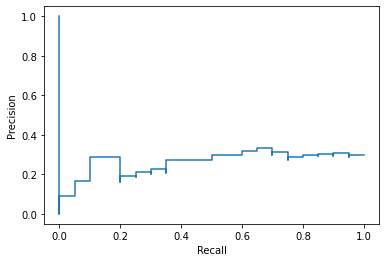

In [8]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


In [ ]:
clf.coef_

In [ ]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test, y_test = dfc2.get_feature_vectors(split=False)


In [ ]:
dfc1.dff.overlapping_words_rank(text)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

np.array([cosine_similarity([x],query_vector)[0][0] for x in dfc1.dff.fitted_vectorizer.toarray()])

In [ ]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train = dfc1.dff.fitted_vectorizer.toarray()
_, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test = dfc2.dff.fitted_vectorizer.toarray()
_, y_test = dfc2.get_feature_vectors(split=False)

xg_reg = xgb.XGBRegressor(objective ='rank:map', eval_metric='map', n_jobs=multiprocessing.cpu_count() // 2)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, preds))
print(score)
preds = xg_reg.predict(X_train)
score = np.sqrt(mean_squared_error(y_train, preds))
score

In [1]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train = dfc1.dff.fitted_vectorizer.toarray()
_, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test = dfc2.dff.fitted_vectorizer.toarray()
_, y_test = dfc2.get_feature_vectors(split=False)

clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False, n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))

NameError: name 'DataFrameClassifier' is not defined

In [ ]:
from sklearn.metrics import average_precision_score

average_precision_score()

In [31]:

dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision', verbose=False)
X_train, y_train = dfc1.get_feature_vectors(split=False)

dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Fish processing equipment', verbose=False)
X_test, y_test = dfc2.get_feature_vectors(split=False)

clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False, n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train)
#xg_reg = xgb.XGBRegressor(objective ='binary:logistic', eval_metric='map', n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train)

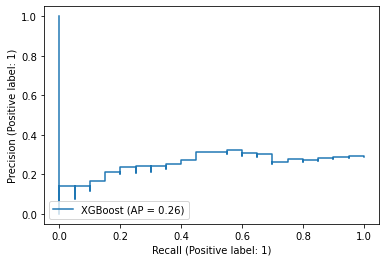

In [34]:
preds = xg_reg.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, preds,name="XGBoost")
plt.show()

Average precision: 0.30496221509588284


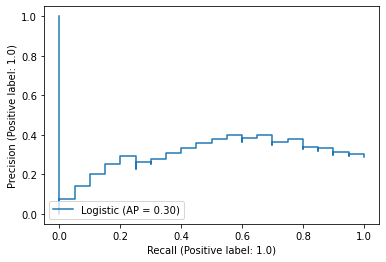

In [35]:
ap = average_precision_score(y_test,clf.decision_function(X_test))
print(f"Average precision: {ap}")

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test,name="Logistic")
plt.show()

### train one test all

In [4]:
dfcs = {}
predictions = [[] for _ in range(len(file_names))]
accuracies = [[] for _ in range(len(file_names))]

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    #X_train, y_train = dfcs[train_file].get_feature_vectors(split=False)
    X_train = dfcs[train_file].dff.fitted_vectorizer.toarray()
    _, y_train = dfcs[train_file].get_feature_vectors(split=False)

    for test_file in file_names:
        #X_test, y_test = dfcs[test_file].get_feature_vectors(split=False)
        X_test = dfcs[test_file].dff.fitted_vectorizer.toarray()
        _, y_test = dfcs[test_file].get_feature_vectors(split=False)

        xg_reg = xgb.XGBRegressor(objective ='binary:logistic', eval_metric='map', n_jobs=multiprocessing.cpu_count() // 2).fit(X_train, y_train).fit(X_train, y_train)
        preds = xg_reg.predict(X_test)
        
        score = np.sqrt(mean_squared_error(y_test, preds))
        predictions[i].append(preds)
        accuracies[i].append(score)

100%|██████████| 20/20 [00:01<00:00, 18.77it/s]
20it [03:54, 11.72s/it]


In [5]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [6]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc)

Average accuracy: 0.5733675200946563
---
{'Computer vision': 0.5985386427753033, 'Consulting': 0.5306447633964371, 'Fintech': 0.5539540906516077, 'Fish processing equipment': 0.6696073727507705, 'Healthcare': 0.6108111440736649, 'House builders': 0.5743632830017719, 'Industrial vertical investor': 0.5479056802480146, 'Innovative': 0.5873130611496012, 'IoT': 0.6052741262222618, 'IT freelance': 0.5464988602703428, 'M&A advisors': 0.5562092997994845, 'Manufacturers': 0.5272866173092972, 'Online games': 0.5323105629768092, 'Payments tech': 0.5247014406281785, 'PE fund': 0.59213556757907, 'Procurement software': 0.6279393212864702, 'Resource-efficiency': 0.5681412896927563, 'SaaS': 0.5709281307402663, 'Sustainability': 0.5873324474515732, 'Wind turbine tech': 0.5554546998894458}


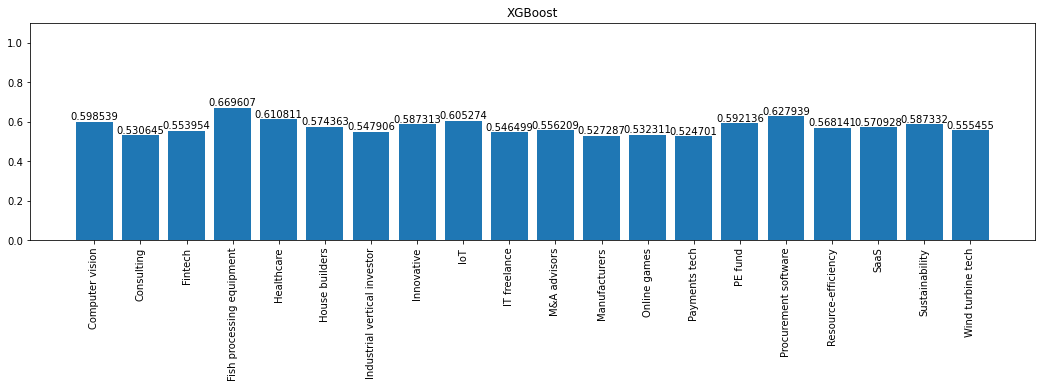

In [8]:
_,_ = plot_accuracies(acc, "XGBoost")
plt.show()

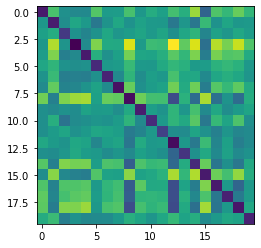

In [9]:
plt.imshow(accuracies)